# Burden Comparison Demo

In [8]:
import sys
sys.path.append('..')
import utils
import pandas as pd
import numpy as np

## Set Constants

In [9]:
S = 1
click = 1
search = 4
AI = 1.5
QA = 3.5
RR = 4
constants = [S, click, search, AI, QA, RR]

TPR_d = 0.8
FPR_d = 0.03
P_sec_read = 0.05

## Load and Clean Data

In [11]:
data = pd.read_csv('../../data/namdinh.csv').fillna(0)

/Users/msanch35/Documents/6.871/RadAI_Usage/radAI/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (27,33,61,65,69,71,81,82,103,104,106,107,113,114,116,117,120,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
drop = ['border', 
         'covid', 
         'fibrosis', 
         'pulmonary_scar', 
         'lung_opacity', 
         'airspace_opacity', 
         'other_findings']

findings = []
for i in list(data.columns):
    if 'ai_' == i[0:3]:
        add = True
        for j in drop:
            if j in i:
                add=False
        if add:    
            findings.append(i[3::])

### Merge Eqiuvalent Findings

In [13]:
data['opacity'] = data[['lung_opacity', 'airspace_opacity']].max(axis=1)
data['ai_opacity'] = data[['ai_lung_opacity', 'ai_airspace_opacity']].max(axis=1)

data['lung_scar'] = data[['fibrosis', 'pulmonary_scar']].max(axis=1)
data['ai_lung_scar'] = data[['ai_fibrosis', 'ai_pulmonary_scar']].max(axis=1)

### Set Clinically Significant Findings

In [14]:
sig_findings = [
    'cardiomegaly',
    'cavitation',
    'consolidation',
    'edema',
    'enlarged_cardiomediastinum',
    'fracture',
    'lung_lesion',
    'opacity',
    'mass',
    'mass_nodule',
    'nodule',
    'pleural_effusion',
    'pneumonia',
    'pneumothorax',
    'tuberculosis',
    'widening_mediastinum'
]
non_sig_findings = [i for i in findings if i not in sig_findings]
non_sig_findings

['no_finding', 'atelectasis', 'pleural_other', 'medical_device']

In [15]:
np.sum(np.array(utils.pipeline_comparison_by_leaf_base(data, findings, constants,weighted=True))*21)

27.25578529064643

/Users/msanch35/Documents/6.871/RadAI_Usage/radAI/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


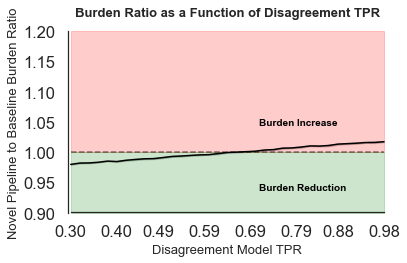

In [16]:
utils.plot_Disagreement_sim_TPR_line(data, FPR_d, P_sec_read, findings, sig_findings, constants,
                                     TPR_ds = np.arange(0.3, 1, 0.02), 
                                     text=True, n_trials = 10, save_fig = True)

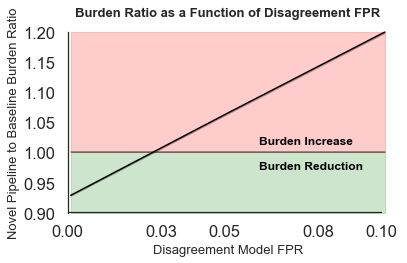

In [20]:
utils.plot_Disagreement_sim_FPR_line(data, TPR_d, P_sec_read, findings, sig_findings, constants,
                                     FPR_ds = np.arange(0.001, 0.12, 0.05), 
                                     text=True, n_trials = 10, save_fig = True)

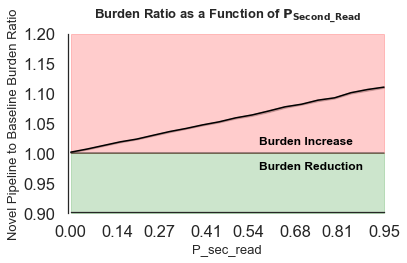

In [21]:
utils.plot_Disagreement_sim_Pred_Qual_line(data, TPR_d, FPR_d, findings, sig_findings, constants,
                                           P_sec_reads = np.arange(0, 1, 0.05),
                                           text=True, n_trials = 10, save_fig = True)

In [32]:
avg_ratio = 0
for i in range(10):
    avg_ratio += utils.pipeline_comparison(data, 0.8, 0.03, 0.05, findings, sig_findings, constants, print_it=False)
avg_ratio / 10

1.0054041817662103